# Transfer learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/dataset_greek_latin.zip

In [ ]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
import torch
from PIL import Image
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
from tqdm import tqdm

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(12345)

Для классификации используем собранный датасет с греческими и латинскими надписями.

In [ ]:
dataset_path = '/content/dataset_greek_latin'

image_paths_greek = glob(os.path.join(dataset_path, '**', 'greek', '*.jpg'), recursive=True)
image_paths_latin = glob(os.path.join(dataset_path, '**', 'latin', '*.jpg'), recursive=True)

In [ ]:
len(image_paths_greek), len(image_paths_latin)

(100, 100)

In [ ]:
img1 = cv2.imread(image_paths_greek[2])[:,:,::-1]
img2 = cv2.imread(image_paths_latin[2])[:,:,::-1]

height = img1.shape[0]
img2_resized = cv2.resize(img2, (img2.shape[1], height))

img = np.concatenate([img1, img2_resized], axis=1)
Image.fromarray(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_image_feature(image_path, resolution=(128, 128)):
  image_rgb = cv2.imread(image_path)
  image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, resolution)

  hog = cv2.HOGDescriptor()
  feature = hog.compute(image, winStride=(8, 8), padding=(0, 0))
  return feature

In [ ]:
dataset = [(get_image_feature(image_path), 0) for image_path in image_paths_greek] + \
          [(get_image_feature(image_path), 1) for image_path in image_paths_latin]

random.shuffle(dataset)

dataset_train = dataset[:int(0.8*len(dataset))]
dataset_train_features = [el[0] for el in dataset_train]
dataset_train_labels = [el[1] for el in dataset_train]

dataset_test  = dataset[int(0.8*len(dataset)):]
dataset_test_features = [el[0] for el in dataset_test]
dataset_test_labels = [el[1] for el in dataset_test]

print(len(dataset_train), len(dataset_test))

160 40


In [ ]:
batch_size = 24
n_epochs = 40
device = 'cuda:0'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/dataset_greek_latin', transform=transform)
valid_size = int(len(dataset) * 0.1)
train_set, valid_set = torch.utils.data.random_split(dataset, [len(dataset) - valid_size, valid_size])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def train_and_evaluate_model(model, model_name):
    for param in model.parameters():
        param.requires_grad = False

    if isinstance(model, torchvision.models.ResNet):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, torchvision.models.DenseNet):
        model.classifier = torch.nn.Linear(model.classifier.in_features, 1)

    model.to(device)

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = []
        for data, target in tqdm(train_dataloader, desc=f'Epoch {epoch} [{model_name}]'):
            data, target = data.to(device), target.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            train_loss.append(loss.item())
            optimizer.step()

        val_loss = []
        model.eval()
        with torch.no_grad():
            for data, target in valid_dataloader:
                data, target = data.to(device), target.to(device).unsqueeze(1).float()
                output = model(data)
                loss = criterion(output, target)
                val_loss.append(loss.item())

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

    pred_list = []
    y_list = []
    with torch.no_grad():
        for data, target in valid_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.sigmoid(output)
            pred_list.extend(preds.cpu().numpy().flatten())
            y_list.extend(target.cpu().numpy())

    model_prs = [1 if p >= 0.5 else 0 for p in pred_list]

    print(classification_report(y_list, model_prs))

    cm = confusion_matrix(y_list, model_prs)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fpr, tpr, _ = roc_curve(y_list, pred_list)
    auc_score = roc_auc_score(y_list, pred_list)
    return fpr, tpr, auc_score

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Epoch 1, train loss: 0.6827, valid loss: 0.7497.


Epoch 2 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


Epoch 2, train loss: 0.6684, valid loss: 0.6936.


Epoch 3 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 3, train loss: 0.6532, valid loss: 0.6542.


Epoch 4 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Epoch 4, train loss: 0.6444, valid loss: 0.6179.


Epoch 5 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch 5, train loss: 0.6251, valid loss: 0.5981.


Epoch 6 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 6, train loss: 0.6160, valid loss: 0.6043.


Epoch 7 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 7, train loss: 0.5949, valid loss: 0.5918.


Epoch 8 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch 8, train loss: 0.5834, valid loss: 0.5660.


Epoch 9 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]


Epoch 9, train loss: 0.5623, valid loss: 0.5628.


Epoch 10 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


Epoch 10, train loss: 0.5578, valid loss: 0.5648.


Epoch 11 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]


Epoch 11, train loss: 0.5561, valid loss: 0.5442.


Epoch 12 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]


Epoch 12, train loss: 0.5415, valid loss: 0.5337.


Epoch 13 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 13, train loss: 0.5399, valid loss: 0.5295.


Epoch 14 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


Epoch 14, train loss: 0.5159, valid loss: 0.5202.


Epoch 15 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


Epoch 15, train loss: 0.4997, valid loss: 0.5082.


Epoch 16 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch 16, train loss: 0.5016, valid loss: 0.5039.


Epoch 17 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch 17, train loss: 0.4893, valid loss: 0.5032.


Epoch 18 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


Epoch 18, train loss: 0.4908, valid loss: 0.4883.


Epoch 19 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch 19, train loss: 0.4763, valid loss: 0.4998.


Epoch 20 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Epoch 20, train loss: 0.4802, valid loss: 0.4991.


Epoch 21 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]


Epoch 21, train loss: 0.4695, valid loss: 0.4851.


Epoch 22 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]


Epoch 22, train loss: 0.4818, valid loss: 0.4741.


Epoch 23 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


Epoch 23, train loss: 0.4740, valid loss: 0.4692.


Epoch 24 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 24, train loss: 0.4516, valid loss: 0.4674.


Epoch 25 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch 25, train loss: 0.4560, valid loss: 0.4593.


Epoch 26 [ResNet50]: 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]


Epoch 26, train loss: 0.4526, valid loss: 0.4673.


Epoch 27 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch 27, train loss: 0.4256, valid loss: 0.4699.


Epoch 28 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


Epoch 28, train loss: 0.4210, valid loss: 0.4617.


Epoch 29 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


Epoch 29, train loss: 0.4356, valid loss: 0.4520.


Epoch 30 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch 30, train loss: 0.4217, valid loss: 0.4491.


Epoch 31 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


Epoch 31, train loss: 0.4188, valid loss: 0.4534.


Epoch 32 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


Epoch 32, train loss: 0.4161, valid loss: 0.4596.


Epoch 33 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 33, train loss: 0.4001, valid loss: 0.4551.


Epoch 34 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


Epoch 34, train loss: 0.4168, valid loss: 0.4455.


Epoch 35 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch 35, train loss: 0.3952, valid loss: 0.4461.


Epoch 36 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 36, train loss: 0.4060, valid loss: 0.4357.


Epoch 37 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Epoch 37, train loss: 0.3991, valid loss: 0.4364.


Epoch 38 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Epoch 38, train loss: 0.3828, valid loss: 0.4234.


Epoch 39 [ResNet50]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 39, train loss: 0.3800, valid loss: 0.4306.


Epoch 40 [ResNet50]: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


Epoch 40, train loss: 0.4036, valid loss: 0.4390.
              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.56      1.00      0.71         5

    accuracy                           0.80        20
   macro avg       0.78      0.87      0.78        20
weighted avg       0.89      0.80      0.81        20



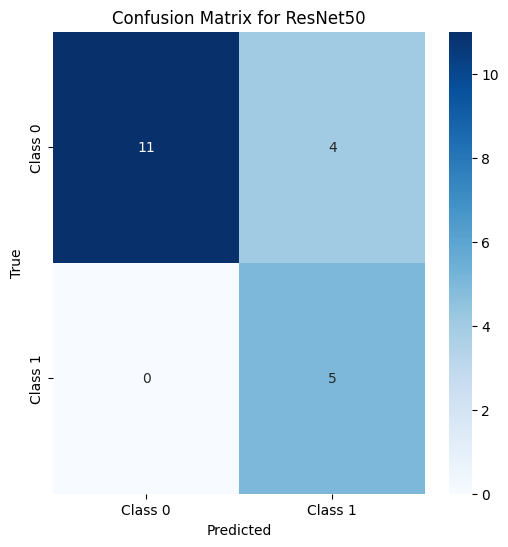

Epoch 1 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 1, train loss: 0.6855, valid loss: 0.7541.


Epoch 2 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


Epoch 2, train loss: 0.6655, valid loss: 0.7486.


Epoch 3 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 3, train loss: 0.6554, valid loss: 0.7457.


Epoch 4 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 4, train loss: 0.6327, valid loss: 0.7454.


Epoch 5 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch 5, train loss: 0.6269, valid loss: 0.7175.


Epoch 6 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 6, train loss: 0.5908, valid loss: 0.7141.


Epoch 7 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Epoch 7, train loss: 0.5952, valid loss: 0.7207.


Epoch 8 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 8, train loss: 0.5795, valid loss: 0.7129.


Epoch 9 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 9, train loss: 0.5646, valid loss: 0.6807.


Epoch 10 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch 10, train loss: 0.5607, valid loss: 0.6726.


Epoch 11 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]


Epoch 11, train loss: 0.5420, valid loss: 0.6505.


Epoch 12 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


Epoch 12, train loss: 0.5405, valid loss: 0.6684.


Epoch 13 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]


Epoch 13, train loss: 0.5212, valid loss: 0.6710.


Epoch 14 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 14, train loss: 0.5121, valid loss: 0.6796.


Epoch 15 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Epoch 15, train loss: 0.5043, valid loss: 0.6659.


Epoch 16 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch 16, train loss: 0.4903, valid loss: 0.6446.


Epoch 17 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


Epoch 17, train loss: 0.4960, valid loss: 0.6275.


Epoch 18 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Epoch 18, train loss: 0.4759, valid loss: 0.6455.


Epoch 19 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


Epoch 19, train loss: 0.4689, valid loss: 0.6431.


Epoch 20 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 20, train loss: 0.4603, valid loss: 0.6316.


Epoch 21 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch 21, train loss: 0.4614, valid loss: 0.6447.


Epoch 22 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Epoch 22, train loss: 0.4496, valid loss: 0.6451.


Epoch 23 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]


Epoch 23, train loss: 0.4588, valid loss: 0.6291.


Epoch 24 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]


Epoch 24, train loss: 0.4570, valid loss: 0.6469.


Epoch 25 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 25, train loss: 0.4425, valid loss: 0.6302.


Epoch 26 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 26, train loss: 0.4365, valid loss: 0.6248.


Epoch 27 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


Epoch 27, train loss: 0.4138, valid loss: 0.6220.


Epoch 28 [DenseNet121]: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]


Epoch 28, train loss: 0.4270, valid loss: 0.6396.


Epoch 29 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


Epoch 29, train loss: 0.4113, valid loss: 0.6378.


Epoch 30 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Epoch 30, train loss: 0.4004, valid loss: 0.6347.


Epoch 31 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 31, train loss: 0.4259, valid loss: 0.6393.


Epoch 32 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch 32, train loss: 0.4018, valid loss: 0.6294.


Epoch 33 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Epoch 33, train loss: 0.4149, valid loss: 0.6232.


Epoch 34 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Epoch 34, train loss: 0.4056, valid loss: 0.6116.


Epoch 35 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]


Epoch 35, train loss: 0.3964, valid loss: 0.6230.


Epoch 36 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]


Epoch 36, train loss: 0.3728, valid loss: 0.6317.


Epoch 37 [DenseNet121]: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch 37, train loss: 0.3636, valid loss: 0.6198.


Epoch 38 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]


Epoch 38, train loss: 0.4090, valid loss: 0.6294.


Epoch 39 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


Epoch 39, train loss: 0.3735, valid loss: 0.6102.


Epoch 40 [DenseNet121]: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 40, train loss: 0.3971, valid loss: 0.6139.
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.44      0.80      0.57         5

    accuracy                           0.70        20
   macro avg       0.68      0.73      0.67        20
weighted avg       0.79      0.70      0.72        20



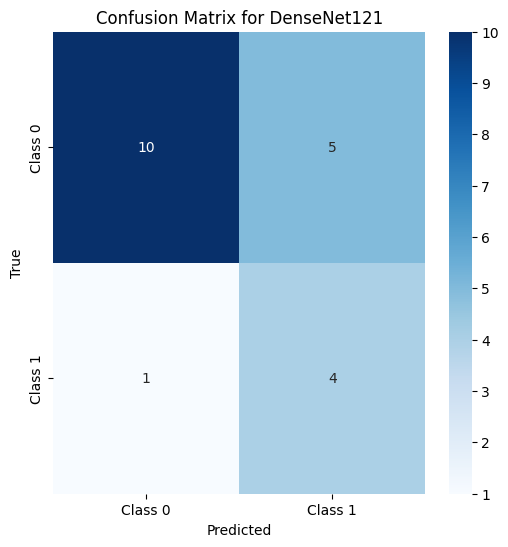

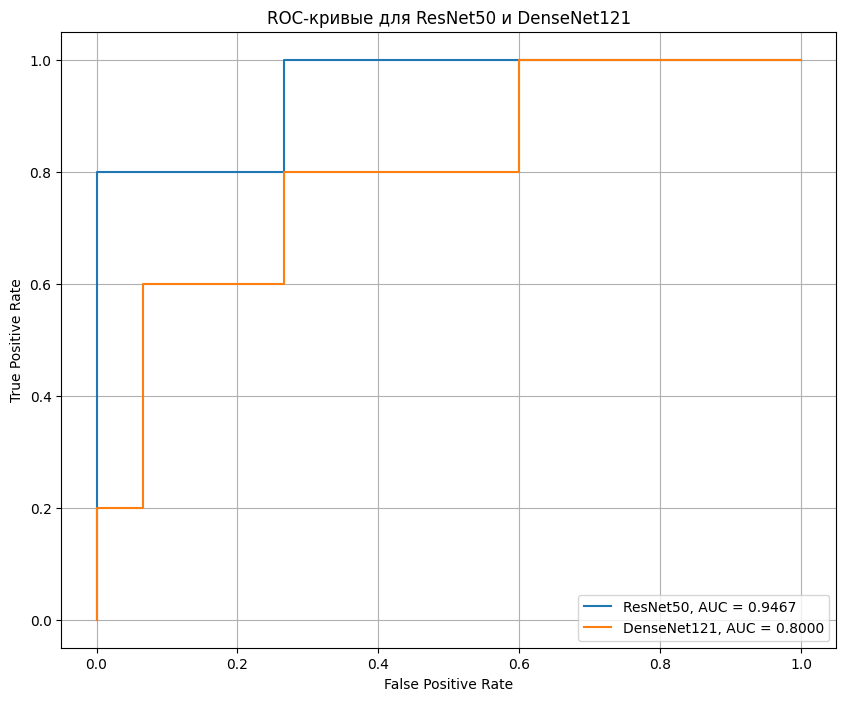

In [ ]:
models = {
    'ResNet50': torchvision.models.resnet50(pretrained=True),
    'DenseNet121': torchvision.models.densenet121(pretrained=True)
}

roc_curves = {}

for model_name, model in models.items():
    fpr, tpr, auc_score = train_and_evaluate_model(model, model_name)
    roc_curves[model_name] = (fpr, tpr, auc_score)

plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name}, AUC = {auc_score:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для ResNet50 и DenseNet121')
plt.legend()
plt.grid(True)
plt.show()